In [59]:
%cd '/home/hew/python/genhance/'
%ls

/home/hew/python/genhance
ACE2/  debug/   temp/         transformers_custom/  visualize/
data/  output/  tensorboard/  vis/


In [60]:
!nvidia-smi

Fri Apr 28 08:51:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   39C    P0    73W / 400W |  18647MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  Off  | 00000000:00:06.0 Off |                    0 |
| N/A   

In [61]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from pathlib import Path

In [62]:
before_foldx = True

In [64]:
train_data_path = '/home/hew/python/genhance/data/train_new_all_data.pkl'
# congen_name = 'congen8_new_ddG_6_layer'
# congen_name = 'congen9_new_solubility_6_layer'
congen_name = 'congen10_new_ddG_solubility_6_layer'

ckpt_step = 'final'
# dir = 'generations_[12.0]_[1.0]'
dir = 'generations_[-30.0]_[1.0]_[1.0]'

pkl_dir = f'/home/hew/storage/storage/genhance/ckpts/{congen_name}/{dir}/'

In [65]:
list(os.walk(pkl_dir))[0]

('/home/hew/storage/storage/genhance/ckpts/congen10_new_ddG_solubility_6_layer/generations_[-30.0]_[1.0]_[1.0]/',
 [],
 ['congen10_new_ddG_solubility_6_layer-latent-260000.pkl',
  'congen10_new_ddG_solubility_6_layer-gens-260000.tsv',
  'congen10_new_ddG_solubility_6_layer-gens-163918-260000.pkl',
  'congen10_new_ddG_solubility_6_layer-gens-260000.pkl'])

In [67]:
index = -3
file = list(os.walk(pkl_dir))[0][-1][index]
tsv_path = f'/home/hew/storage/storage/genhance/ckpts/{congen_name}/{dir}/{file}'
tsv_path

'/home/hew/storage/storage/genhance/ckpts/congen10_new_ddG_solubility_6_layer/generations_[-30.0]_[1.0]_[1.0]/congen10_new_ddG_solubility_6_layer-gens-260000.tsv'

In [68]:
# suffix = '[12.0]_[1.0]'
suffix = '[-30.0]_[1.0]_[1.0]'
output_dir = f'/home/hew/python/genhance/output/{congen_name}_gens_step_{ckpt_step}_{suffix}/'
output_dir = Path(output_dir)
output_dir.mkdir(parents=True, exist_ok=True)
output_dir

PosixPath('/home/hew/python/genhance/output/congen10_new_ddG_solubility_6_layer_gens_step_final_[-30.0]_[1.0]_[1.0]')

In [69]:
wt_seq = 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ'
WT_seq = 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ'
constant_region = 'NTNITEEN'
wt_cs_ind = wt_seq.index(constant_region)
wt_cs_ind, wt_seq[32:32 + 8]

(32, 'NTNITEEN')

# Analyze 250K gen seqs and prepare for FoldX

In [70]:
gen250k_df = pd.read_table(tsv_path)
gen250k_df

,MT_seq,ddG_latent_pred,solubility_latent_pred,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen,ddG_latent_pred_rank,solubility_latent_pred_rank,avg_latent_head_pred_rank
0,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.307658,7.495675,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,18557.0,12982.0,15769.5
1,SDIEEQAKTFLDKFNHEAEDFQYQSSLASWNYNTNITEENVQNMNN...,-9.772393,7.918597,SDIEEQAKTFLDKFNHEAEDLQYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,22064.0,10351.0,16207.5
2,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-9.608262,8.043570,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,23185.0,9634.0,16409.5
3,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.861493,7.116463,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,15181.0,17658.0,16419.5
4,STIEEQAKIFLDKFNHEAEDFFYQSSLASWFYNTNITEENVQNMNN...,-10.735771,7.133160,STIEEQAKTFLDKFNHEAEDLFYQSFLASWIYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,15890.0,17378.0,16634.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260057,STIEEQAKTFLDKFNHEASDSFYQSSIASWNYNTNITEENVQNMNN...,1.796386,-2.401845,STIEEQAKTFLDKFNHEAEDSFYQSSIASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,251122.0,255865.0,253493.5
260058,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITESGQVSLNI...,2.174142,-1.381156,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQDMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,253471.0,254150.0,253810.5
260059,STIEEQAKTFLDKFNHEAEDLFYYSSLASWNYNTNITEIQNQTLQD...,2.470599,-1.585549,STIEEQAKTFLDKFNHEAEDLFYYSSLASWNYNTNITEENVQNMQN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,254795.0,254779.0,254787.0
260060,STIEEQAKTFLDKFNHQAEDLFYQSSLAMWNKNTNITQENVQAMSN...,2.845864,-1.392259,STIEEQAKTFLDKFNHEAEDLFYQSSLAKWNMNTNITEENVQAMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,255969.0,254200.0,255084.5


In [71]:
MT_seq_lens = [len(seq) for seq in gen250k_df.MT_seq]
set(MT_seq_lens)

{83, 87, 91, 95}

## filter out sequences without constant region

In [72]:
constant_region in gen250k_df.iloc[0]['MT_seq']

True

In [73]:
indices_to_drop = []
dropped_seqs = []
num_contain_non_bias_cons = 0
num_contain_bias_cons = 0
for index, row in gen250k_df.iterrows():
    seq = row['MT_seq']
    if constant_region not in seq:
        indices_to_drop.append(index)
        dropped_seqs.append(seq)
    else:
        num_contain_non_bias_cons += 1
        cs_ind = seq.index(constant_region)
        if cs_ind != wt_cs_ind:
            indices_to_drop.append(index)
            dropped_seqs.append(seq)
            num_contain_bias_cons += 1

In [74]:
print(len(indices_to_drop))
print(indices_to_drop[:10])
print(dropped_seqs[:10])

31007
[11, 14, 28, 49, 58, 69, 98, 111, 114, 118]
['STIEEQAKIFMDKFNHEAEDFIYQASIEFWNYNTNITEERIQNMNNAVDKWSAFLKEMSDIAQMYPLQEIQNLTVKLQLQALQ', 'STIEEQAKTFMDKFNHEAEDIFYQWSFASWNYNTNINEENVQNMNNAGDKWSAFLKEMSDLAQMYPLQEIQNLTVKLQLQALQ', 'STIEEQAKTFLDKFNHEAEDRFYQSSIESWNYNTNITEDNVQNMANAFDRWSAFLKEMATLAQMFPLQEIQNLTVKFMLQALQ', 'STIEEQAKIFLDKFNHEAEDLFYQSMLASWNYNTNITEEAIQNMNNAGDKWSAFLKEQSTIAQMYPLQEIQNETVKLQLQALQ', 'STIEEQAKTFLDMFNNEAEDVFYQSSLASWNYNTNIIEESAQNMFNANDKWSAFLKEQSTLAQMYPLQEIQNWFVKMQLQALQ', 'STIEEQAKTFLDKFNHEAEDFFYQSMLANWNYNTNIIEENVQNMNNAAEKWSAFLKEQSTMAQMYPLQDIQNETVKLQLQALQ', 'SSIEEQAKYFLDKFNKEAEDLFYQSSLASWNYNTNITEEKVQNMNNAGDKWSAFLKEQATIAQMYPLQEIQNETVKVQLQALQ', 'STIEEQAKTFLDKFNHEAEDIFYQSSLASWNYNTNITEINVQNMNNAADKWSAFLKEQSTLAQMYPPQEIENWTVKLQLQALQ', 'STIEEQAKTFLDKFNHEAEDIFYQSSLASWNYNTNINEENVVNMNNAKAKWESFLKEQSTLAQMYPPQEIQNVPVKLQLEALQ', 'STIEEQAKFFLDKFNHEAEDMFYQSSIAMWNYNTNITEEAVQNMMNAGDKWSAFFKEQSTMAQMYPPQEIQNLTVKLQLQALQ']


In [75]:
gen250k_df_dropped_nocon = gen250k_df.drop(indices_to_drop)
len(gen250k_df_dropped_nocon)

229055

## filter out sequences with non-AA tokens

In [76]:
# do not constant region
# gen250k_df_dropped_nocon = gen250k_df

In [77]:
rejected_tokens = ["<pad>", "<sep>", "<cls>", "<mask>", "<unk>"]

In [78]:
indices_to_drop = []
dropped_seqs = []
for index, row in gen250k_df_dropped_nocon.iterrows():
    seq = row['MT_seq']

    for rejected_token in rejected_tokens:
        if rejected_token in seq:
            indices_to_drop.append(index)
            dropped_seqs.append(seq)
            break

In [79]:
print(len(indices_to_drop))
print(indices_to_drop[:10])
print(dropped_seqs[:10])

701
[834, 938, 1056, 2247, 2848, 3273, 3780, 4515, 4590, 4793]
['STIEEQAKTFLDKFNHEAEDLFYQSSLAAWNYNTNITEENVQNMNNAKEKWSFFLKEQSA<cls>AQMYPLQEIQNLTVKIQMQALQ', 'STIEEMAKTFLDKFNHEAEDLFYQSSLAAWNYNTNITEENVQNMNNAADKWSWFFKEESTLAQMYPLQEIQNLTVK<cls>QMQALQ', 'STIEEQAKTFLDKFNHEAEDMFYQSSMASWNYNTNITEENVQNMINANEKWSAFIKEKS<cls>LAQMYPLQEIQNLTVKVMLQNLK', 'STIEEDAKFFLDKFNHEAEDIFYQSSLASWKYNTNITEEN<cls>QAMNNFADKWSAFLKEISTLAQMYPLQEIQNLTVKLQLQALQ', 'STIEEQAKIFLDKFNHEAEDLFYQFSLARWFYNTNITEENVQNMNNAGDKWSAFLKEISTLAQMYPRQEIQD<cls>TTKLQLQALQ', 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKERSTRAQMFPLQEIQNWTVK<cls>QLQFLQ', 'STIEEQAKTFLDKFNHEAEDLFYQMSLASWNYNTNITEENVQNMNNAEDKWSAFLKEQSTLANMYPLQEI<cls>NLTVKLQLMALQ', 'STIEEQAKTFLDKFNHEAEDLFYQSALKSWNFNTNITEEN<cls>QAMNNLGDKWEAFLKEQSTLAQMFPLQEIQNLTVKLQLQALQ', 'SDIEEQAGKFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNASDKWSAFLKEQSTLAQMYPLKEIQNL<cls>VKLQLQALQ', 'SEIEEQAKTFLEKFNHEAEDWFYMSSLMAWNYNTNITEENVQNMNNAGDKWHAFLKEQST<cls>AQMYPLQEIQNLTVKLQLQALQ']


In [80]:
gen250k_df_dropped = gen250k_df_dropped_nocon.drop(indices_to_drop)
gen250k_df_dropped

,MT_seq,ddG_latent_pred,solubility_latent_pred,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen,ddG_latent_pred_rank,solubility_latent_pred_rank,avg_latent_head_pred_rank
0,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.307658,7.495675,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,18557.0,12982.0,15769.5
1,SDIEEQAKTFLDKFNHEAEDFQYQSSLASWNYNTNITEENVQNMNN...,-9.772393,7.918597,SDIEEQAKTFLDKFNHEAEDLQYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,22064.0,10351.0,16207.5
2,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-9.608262,8.043570,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,23185.0,9634.0,16409.5
3,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.861493,7.116463,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,15181.0,17658.0,16419.5
4,STIEEQAKIFLDKFNHEAEDFFYQSSLASWFYNTNITEENVQNMNN...,-10.735771,7.133160,STIEEQAKTFLDKFNHEAEDLFYQSFLASWIYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,15890.0,17378.0,16634.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260050,STIEEQAQTYLNKFNHEAEDLFYQSRLASWNANTNITEENVQNMNN...,1.761667,-1.814477,STIEEQAQTFLDKFNHEAEDLFYQSRLASWNANTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,250869.0,255201.0,253035.0
260053,STIEEQAKTFLDKFNHEAADLFYQSSLASWNYNTNITEENVQNMNN...,1.819618,-1.662608,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,251297.0,254927.0,253112.0
260054,SIIEEQAKTFLDKFNHEAVDFFYQSSLASWNYNTNITEENVQNMNN...,1.718763,-2.332379,SIIEEQAKTFLDKFNHEAEDFFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,250527.0,255794.0,253160.5
260055,STIEEQAQTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,2.285915,-1.257594,STIEEQAQTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,253990.0,252452.0,253221.0


## filter out sequences that are repeat or in training set

In [81]:
input_data_df = pd.read_pickle(train_data_path)
input_data_df

,PDB,Chain,Start_index,WT_seq,MT_seq,solubility,ddG,ddG_std,ddG_rank,solubility_rank,avg_rank
0,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,0.764,0.487536,0.173732,27073.0,114868.5,70970.75
1,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIELQAKDFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,0.701,1.671400,0.154878,51857.0,226709.0,139283.00
2,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,0.769,6.211590,0.087345,150915.0,68731.0,109823.00
3,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,0.807,9.822730,2.028930,201957.0,12266.5,107111.75
4,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKPFLDKFNHEAEDLFYQHSLASWNYNTNITEENVQNMNN...,0.752,3.106590,0.163249,84850.5,168879.0,126864.75
...,...,...,...,...,...,...,...,...,...,...,...
249995,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDLFYQDSLASWNYNTNITEENVQNMNN...,0.781,2.569060,0.042348,72549.0,43637.0,58093.00
249996,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMFN...,0.764,3.736110,0.500392,99288.0,114868.5,107078.25
249997,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDLDYQSSLASWNYNTNITEENVQNMNN...,0.781,1.555830,0.024263,49188.0,43637.0,46412.50
249998,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,YTIEEQAKTFLDKFNHEAEDMFYVSSLASWNYNTNITEENVQNMNN...,0.824,5.724200,0.292841,141810.0,5272.5,73541.25


In [82]:
input_data_df.ddG.describe()

count    250000.000000
mean          5.958471
std           5.354275
min          -8.449020
25%           2.136552
50%           4.903470
75%           8.573042
max          60.631300
Name: ddG, dtype: float64

In [83]:
input_data_df.iloc[0]['MT_seq']

'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDQWSAFLKEQSTIAQMYPLQEIKNLTVKLVLQALQ'

In [84]:
input_data_df.iloc[0]['MT_seq'] in input_data_df['MT_seq']

False

In [85]:
input_data_df.iloc[0]['MT_seq'] in input_data_df['MT_seq'].tolist()

True

In [86]:
train_seq_list = input_data_df['MT_seq'].tolist()

In [87]:
# all seqs in the training set contain constant region, which binds to SARS-CoV-2 spike protein
sum([1 if constant_region in seq else 0 for seq in train_seq_list])

250000

## filter out those that are repeat

In [88]:
gen250k_df_dropped_norepeat = gen250k_df_dropped[gen250k_df_dropped['repeated_gen'] == False]
gen250k_df_dropped_norepeat

,MT_seq,ddG_latent_pred,solubility_latent_pred,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen,ddG_latent_pred_rank,solubility_latent_pred_rank,avg_latent_head_pred_rank
0,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.307658,7.495675,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,18557.0,12982.0,15769.5
1,SDIEEQAKTFLDKFNHEAEDFQYQSSLASWNYNTNITEENVQNMNN...,-9.772393,7.918597,SDIEEQAKTFLDKFNHEAEDLQYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,22064.0,10351.0,16207.5
2,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-9.608262,8.043570,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,23185.0,9634.0,16409.5
3,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.861493,7.116463,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,15181.0,17658.0,16419.5
4,STIEEQAKIFLDKFNHEAEDFFYQSSLASWFYNTNITEENVQNMNN...,-10.735771,7.133160,STIEEQAKTFLDKFNHEAEDLFYQSFLASWIYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,15890.0,17378.0,16634.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260050,STIEEQAQTYLNKFNHEAEDLFYQSRLASWNANTNITEENVQNMNN...,1.761667,-1.814477,STIEEQAQTFLDKFNHEAEDLFYQSRLASWNANTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,250869.0,255201.0,253035.0
260053,STIEEQAKTFLDKFNHEAADLFYQSSLASWNYNTNITEENVQNMNN...,1.819618,-1.662608,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,251297.0,254927.0,253112.0
260054,SIIEEQAKTFLDKFNHEAVDFFYQSSLASWNYNTNITEENVQNMNN...,1.718763,-2.332379,SIIEEQAKTFLDKFNHEAEDFFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,250527.0,255794.0,253160.5
260055,STIEEQAQTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,2.285915,-1.257594,STIEEQAQTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,253990.0,252452.0,253221.0


## filter out those that are in training set

In [89]:
gen250k_df_filtered = gen250k_df_dropped_norepeat[gen250k_df_dropped_norepeat['in_train_data_gen'] == False]
gen250k_df_filtered

,MT_seq,ddG_latent_pred,solubility_latent_pred,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen,ddG_latent_pred_rank,solubility_latent_pred_rank,avg_latent_head_pred_rank
0,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.307658,7.495675,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,18557.0,12982.0,15769.5
1,SDIEEQAKTFLDKFNHEAEDFQYQSSLASWNYNTNITEENVQNMNN...,-9.772393,7.918597,SDIEEQAKTFLDKFNHEAEDLQYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,22064.0,10351.0,16207.5
2,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-9.608262,8.043570,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,23185.0,9634.0,16409.5
3,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.861493,7.116463,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,15181.0,17658.0,16419.5
4,STIEEQAKIFLDKFNHEAEDFFYQSSLASWFYNTNITEENVQNMNN...,-10.735771,7.133160,STIEEQAKTFLDKFNHEAEDLFYQSFLASWIYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,15890.0,17378.0,16634.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260050,STIEEQAQTYLNKFNHEAEDLFYQSRLASWNANTNITEENVQNMNN...,1.761667,-1.814477,STIEEQAQTFLDKFNHEAEDLFYQSRLASWNANTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,250869.0,255201.0,253035.0
260053,STIEEQAKTFLDKFNHEAADLFYQSSLASWNYNTNITEENVQNMNN...,1.819618,-1.662608,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,251297.0,254927.0,253112.0
260054,SIIEEQAKTFLDKFNHEAVDFFYQSSLASWNYNTNITEENVQNMNN...,1.718763,-2.332379,SIIEEQAKTFLDKFNHEAEDFFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,250527.0,255794.0,253160.5
260055,STIEEQAQTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,2.285915,-1.257594,STIEEQAQTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,253990.0,252452.0,253221.0


In [90]:
np.sum(gen250k_df_filtered['repeated_gen'])

0

In [91]:
np.sum(gen250k_df_filtered['in_train_data_gen'])

0

# Analyze hamming distance

In [92]:
# Compute hamming distance between MT and WT
def hamming_dist(str1, str2):
    i = 0
    count = 0

    while (i < len(str1)):
        if (str1[i] != str2[i]):
            count += 1
        i += 1
    return count

In [93]:
hamming_dist_list = []
drop_indices = []
for index, row in gen250k_df_filtered.iterrows():
    gen_seq = row['MT_seq']
    h_dist = hamming_dist(gen_seq, wt_seq)
    hamming_dist_list.append(h_dist)
    if h_dist > 8:
        drop_indices.append(index)

In [94]:
print("Hamming distance stats")
print("max: ", np.max(hamming_dist_list))
print("min: ", np.min(hamming_dist_list))
print("median: ", np.median(hamming_dist_list))
print("mean: ", np.mean(hamming_dist_list))
print("std: ", np.std(hamming_dist_list))

Hamming distance stats
max:  49
min:  0
median:  5.0
mean:  5.369588446009266
std:  3.2171150067979006


## hamming distance for generator training data

In [95]:
gen_train_df = pd.read_pickle(train_data_path)
gen_train_hamming_dist_list = []
for index, row in gen_train_df.iterrows():
    train_seq = row['MT_seq']
    h_dist = hamming_dist(train_seq, wt_seq)
    gen_train_hamming_dist_list.append(h_dist)

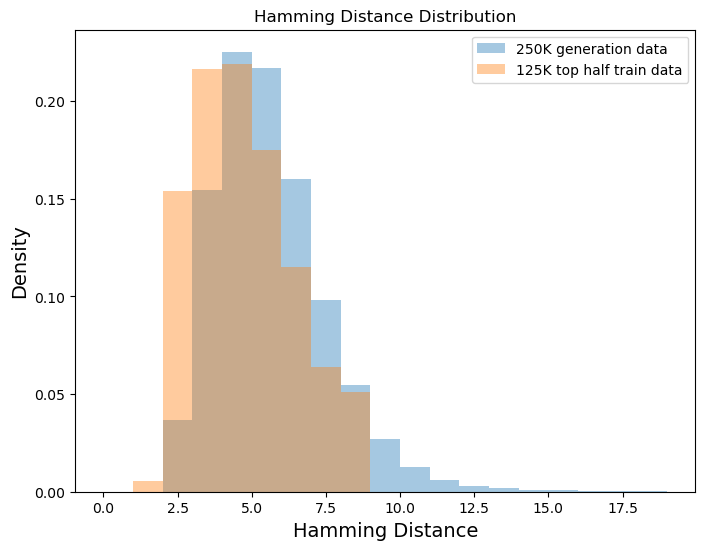

In [96]:
plt.figure(figsize=(8, 6))
plt.hist(hamming_dist_list, density=True, label='250K generation data', bins=[i for i in range(20)], alpha=0.4)
plt.hist(gen_train_hamming_dist_list, density=True, label='125K top half train data', bins=[i for i in range(20)], alpha=0.4)
plt.xlabel("Hamming Distance", size=14)
plt.ylabel("Density", size=14)
plt.title("Hamming Distance Distribution")
plt.legend(loc='upper right')
# plt.savefig('./figures/congen4_distance.png')

## filter out seqs with hamming distance > 8

In [97]:
gen250k_df_filtered

,MT_seq,ddG_latent_pred,solubility_latent_pred,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen,ddG_latent_pred_rank,solubility_latent_pred_rank,avg_latent_head_pred_rank
0,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.307658,7.495675,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,18557.0,12982.0,15769.5
1,SDIEEQAKTFLDKFNHEAEDFQYQSSLASWNYNTNITEENVQNMNN...,-9.772393,7.918597,SDIEEQAKTFLDKFNHEAEDLQYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,22064.0,10351.0,16207.5
2,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-9.608262,8.043570,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,23185.0,9634.0,16409.5
3,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.861493,7.116463,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,15181.0,17658.0,16419.5
4,STIEEQAKIFLDKFNHEAEDFFYQSSLASWFYNTNITEENVQNMNN...,-10.735771,7.133160,STIEEQAKTFLDKFNHEAEDLFYQSFLASWIYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,15890.0,17378.0,16634.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260050,STIEEQAQTYLNKFNHEAEDLFYQSRLASWNANTNITEENVQNMNN...,1.761667,-1.814477,STIEEQAQTFLDKFNHEAEDLFYQSRLASWNANTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,250869.0,255201.0,253035.0
260053,STIEEQAKTFLDKFNHEAADLFYQSSLASWNYNTNITEENVQNMNN...,1.819618,-1.662608,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,251297.0,254927.0,253112.0
260054,SIIEEQAKTFLDKFNHEAVDFFYQSSLASWNYNTNITEENVQNMNN...,1.718763,-2.332379,SIIEEQAKTFLDKFNHEAEDFFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,250527.0,255794.0,253160.5
260055,STIEEQAQTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,2.285915,-1.257594,STIEEQAQTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,253990.0,252452.0,253221.0


In [98]:
gen250k_df_filtered = gen250k_df_filtered.drop(drop_indices)
gen250k_df_filtered

,MT_seq,ddG_latent_pred,solubility_latent_pred,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen,ddG_latent_pred_rank,solubility_latent_pred_rank,avg_latent_head_pred_rank
0,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.307658,7.495675,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,18557.0,12982.0,15769.5
1,SDIEEQAKTFLDKFNHEAEDFQYQSSLASWNYNTNITEENVQNMNN...,-9.772393,7.918597,SDIEEQAKTFLDKFNHEAEDLQYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,22064.0,10351.0,16207.5
2,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-9.608262,8.043570,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,23185.0,9634.0,16409.5
3,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.861493,7.116463,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,15181.0,17658.0,16419.5
4,STIEEQAKIFLDKFNHEAEDFFYQSSLASWFYNTNITEENVQNMNN...,-10.735771,7.133160,STIEEQAKTFLDKFNHEAEDLFYQSFLASWIYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,15890.0,17378.0,16634.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260050,STIEEQAQTYLNKFNHEAEDLFYQSRLASWNANTNITEENVQNMNN...,1.761667,-1.814477,STIEEQAQTFLDKFNHEAEDLFYQSRLASWNANTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,250869.0,255201.0,253035.0
260053,STIEEQAKTFLDKFNHEAADLFYQSSLASWNYNTNITEENVQNMNN...,1.819618,-1.662608,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,251297.0,254927.0,253112.0
260054,SIIEEQAKTFLDKFNHEAVDFFYQSSLASWNYNTNITEENVQNMNN...,1.718763,-2.332379,SIIEEQAKTFLDKFNHEAEDFFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,250527.0,255794.0,253160.5
260055,STIEEQAQTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,2.285915,-1.257594,STIEEQAQTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,253990.0,252452.0,253221.0


# Save top 10/100/1000/10000 seqs for FoldX Evaluation

In [99]:
topK_saved_list = [10000, 1000, 100, 10]
sort_column_list = ['ddG_latent_pred', 'solubility_latent_pred', 'avg_latent_head_pred_rank']
for topk in topK_saved_list:
    for sort_column in sort_column_list:
        if sort_column in gen250k_df_filtered.columns:
            if sort_column == 'ddG_latent_pred' and not gen250k_df_filtered[sort_column].isnull().any():
                prefix = 'ddG'
                ascending = True
            elif sort_column == 'solubility_latent_pred' and not gen250k_df_filtered[sort_column].isnull().any():
                prefix = 'solubility'
                ascending = False
            elif sort_column == 'avg_latent_head_pred_rank':
                prefix = 'ddG_solubility_avg'
                ascending = True
            else:
                continue

            final_topk_df = gen250k_df_filtered.sort_values(by=sort_column, ascending=ascending)
            final_topk_df = final_topk_df.iloc[:topk]
            csv_file = f'{output_dir}/{prefix}_top{topk}.tsv'
            final_topk_df.to_csv(csv_file, sep='\t', index=False)
            print(csv_file)

/home/hew/python/genhance/output/congen10_new_ddG_solubility_6_layer_gens_step_final_[-30.0]_[1.0]_[1.0]/ddG_top10000.tsv
/home/hew/python/genhance/output/congen10_new_ddG_solubility_6_layer_gens_step_final_[-30.0]_[1.0]_[1.0]/solubility_top10000.tsv
/home/hew/python/genhance/output/congen10_new_ddG_solubility_6_layer_gens_step_final_[-30.0]_[1.0]_[1.0]/ddG_solubility_avg_top10000.tsv
/home/hew/python/genhance/output/congen10_new_ddG_solubility_6_layer_gens_step_final_[-30.0]_[1.0]_[1.0]/ddG_top1000.tsv
/home/hew/python/genhance/output/congen10_new_ddG_solubility_6_layer_gens_step_final_[-30.0]_[1.0]_[1.0]/solubility_top1000.tsv
/home/hew/python/genhance/output/congen10_new_ddG_solubility_6_layer_gens_step_final_[-30.0]_[1.0]_[1.0]/ddG_solubility_avg_top1000.tsv
/home/hew/python/genhance/output/congen10_new_ddG_solubility_6_layer_gens_step_final_[-30.0]_[1.0]_[1.0]/ddG_top100.tsv
/home/hew/python/genhance/output/congen10_new_ddG_solubility_6_layer_gens_step_final_[-30.0]_[1.0]_[1.0]/so

In [100]:
topK_saved = 100
# sort_column = 'ddG_latent_pred'
# ascending = True
# sort_column = 'solubility_latent_pred'
# ascending = False
sort_column = 'avg_latent_head_pred_rank'
ascending = True

final_topk_df = gen250k_df_filtered.sort_values(by=sort_column, ascending=ascending)
final_topk_df = final_topk_df.iloc[:topK_saved]
final_topk_df

,MT_seq,ddG_latent_pred,solubility_latent_pred,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen,ddG_latent_pred_rank,solubility_latent_pred_rank,avg_latent_head_pred_rank
0,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.307658,7.495675,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,18557.0,12982.0,15769.5
1,SDIEEQAKTFLDKFNHEAEDFQYQSSLASWNYNTNITEENVQNMNN...,-9.772393,7.918597,SDIEEQAKTFLDKFNHEAEDLQYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,22064.0,10351.0,16207.5
2,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-9.608262,8.043570,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,23185.0,9634.0,16409.5
3,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.861493,7.116463,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,15181.0,17658.0,16419.5
4,STIEEQAKIFLDKFNHEAEDFFYQSSLASWFYNTNITEENVQNMNN...,-10.735771,7.133160,STIEEQAKTFLDKFNHEAEDLFYQSFLASWIYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,15890.0,17378.0,16634.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,STIEEQAKTFLDKFNHEAEDLFYQSMLANWNYNTNITEENVQNMNN...,-11.488681,5.720611,STIEEQAKTFLDKFNHEAEDLFYQSMLANWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,11814.0,30055.0,20934.5
121,STIEEQAKTFMDKFNHEAEDYFYQSSLASWNYNTNITEENVQNMNN...,-10.193822,6.815171,STIEEQAKTFMDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,19278.0,22602.0,20940.0
123,SSIEEQAKYFLEKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-11.530498,5.667688,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,11601.0,30403.0,21002.0
124,STIEEQAKIFLDKFNHEAEDIFYQSSMASWNYNTNITEENVQNMNQ...,-11.554396,5.648527,STIEEQAKTFLDKFNHEAEDIFYQSSIASWNYNTNITEENVQNMNQ...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,11484.0,30560.0,21022.0


In [101]:
topK_saved = 100
# prefix = 'ddG'
# prefix = 'solubility'
prefix = 'ddG_solubility_avg'

csv_file = f'{output_dir}/{prefix}_top{topk}.tsv'
load_topk_data = pd.read_csv(csv_file, sep="\t")
load_topk_data

,MT_seq,ddG_latent_pred,solubility_latent_pred,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen,ddG_latent_pred_rank,solubility_latent_pred_rank,avg_latent_head_pred_rank
0,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.307658,7.495675,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,18557.0,12982.0,15769.5
1,SDIEEQAKTFLDKFNHEAEDFQYQSSLASWNYNTNITEENVQNMNN...,-9.772393,7.918597,SDIEEQAKTFLDKFNHEAEDLQYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,22064.0,10351.0,16207.5
2,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-9.608262,8.043570,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,23185.0,9634.0,16409.5
3,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.861493,7.116463,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,15181.0,17658.0,16419.5
4,STIEEQAKIFLDKFNHEAEDFFYQSSLASWFYNTNITEENVQNMNN...,-10.735771,7.133160,STIEEQAKTFLDKFNHEAEDLFYQSFLASWIYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,15890.0,17378.0,16634.0
5,STIEEQAKTFLDKFNHEAEDIFYQFSLASWIYNTNITEENVQNMNN...,-9.956779,7.559714,STIEEQAKTFLDKFNHEAEDLFYQSFLASWIYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,20812.0,12544.0,16678.0
6,STIEEQAKIFLDKFNHEAEDLFYQSSMMAWNYNTNITEENVQNMNN...,-10.480534,7.110551,STIEEQAKTFLDKFNHEAEDLFYQSSMASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,17472.0,17745.0,17608.5
7,SSIEEQAKYFLEKFNHEAEDYFYQSSLASWNYNTNITEENVQNMNN...,-9.710723,7.466070,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,22532.0,13228.0,17880.0
8,STIEEQAKTFLDKFNHEAEDLFYQSMLANWNYNTNITEENVQNMNN...,-9.395791,7.774136,STIEEQAKTFLDKFNHEAEDLFYQSMLANWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,24710.0,11244.0,17977.0
9,STIEEQAKIFLDKFNHEAEDIFYQSSLASWNYNTNITEENEQNMNN...,-9.580462,7.452818,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENEQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,23392.0,13348.0,18370.0


# Sample for E[min] FoldX Computation

In [102]:
gen250k_df_filtered

,MT_seq,ddG_latent_pred,solubility_latent_pred,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen,ddG_latent_pred_rank,solubility_latent_pred_rank,avg_latent_head_pred_rank
0,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.307658,7.495675,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,18557.0,12982.0,15769.5
1,SDIEEQAKTFLDKFNHEAEDFQYQSSLASWNYNTNITEENVQNMNN...,-9.772393,7.918597,SDIEEQAKTFLDKFNHEAEDLQYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,22064.0,10351.0,16207.5
2,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-9.608262,8.043570,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,23185.0,9634.0,16409.5
3,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.861493,7.116463,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,15181.0,17658.0,16419.5
4,STIEEQAKIFLDKFNHEAEDFFYQSSLASWFYNTNITEENVQNMNN...,-10.735771,7.133160,STIEEQAKTFLDKFNHEAEDLFYQSFLASWIYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,15890.0,17378.0,16634.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260050,STIEEQAQTYLNKFNHEAEDLFYQSRLASWNANTNITEENVQNMNN...,1.761667,-1.814477,STIEEQAQTFLDKFNHEAEDLFYQSRLASWNANTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,250869.0,255201.0,253035.0
260053,STIEEQAKTFLDKFNHEAADLFYQSSLASWNYNTNITEENVQNMNN...,1.819618,-1.662608,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,251297.0,254927.0,253112.0
260054,SIIEEQAKTFLDKFNHEAVDFFYQSSLASWNYNTNITEENVQNMNN...,1.718763,-2.332379,SIIEEQAKTFLDKFNHEAEDFFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,250527.0,255794.0,253160.5
260055,STIEEQAQTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,2.285915,-1.257594,STIEEQAQTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,253990.0,252452.0,253221.0


In [103]:
# Get topk seqs
num_rounds = 100  # N
round_pool_size = 10000
topk = 10  # K

round_topk = {}
# ['ddG_latent_pred', 'solubility_latent_pred', 'avg_latent_head_pred_rank']
# cols_to_sort = ['ddG_latent_pred']
# ascending = True
# cols_to_sort = ['solubility_latent_pred']
# ascending = False
cols_to_sort = ['avg_latent_head_pred_rank']
ascending = True

foldx_df = None
in_count = 0
for col_to_sort in cols_to_sort:
    print("col_to_sort: ", col_to_sort)
    round_topk[col_to_sort] = {}
    for round_ind in range(num_rounds):
        sampled_rows = gen250k_df_filtered.sample(n=round_pool_size)
        sorted_sampled_rows = sampled_rows.sort_values(by=col_to_sort, ascending=ascending)[:topk]
        topk_rows = sorted_sampled_rows[:topk]
        round_topk[col_to_sort][round_ind] = topk_rows

    for round_ind in round_topk[col_to_sort]:
        round_topk_df = round_topk[col_to_sort][round_ind]
        if foldx_df is None:
            foldx_df = round_topk_df
        else:
            all_mt = foldx_df['MT_seq'].tolist()

            for row_ind, row in round_topk_df.iterrows():
                if row['MT_seq'] not in all_mt:
                    foldx_df = foldx_df.append(row)
                else:
                    in_count += 1

    print("len(foldx_df)+in_count: ", len(foldx_df) + in_count)

col_to_sort:  avg_latent_head_pred_rank


/tmp/ipykernel_16009/1355194123.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  foldx_df = foldx_df.append(row)
/tmp/ipykernel_16009/1355194123.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  foldx_df = foldx_df.append(row)
/tmp/ipykernel_16009/1355194123.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  foldx_df = foldx_df.append(row)
/tmp/ipykernel_16009/1355194123.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  foldx_df = foldx_df.append(row)
/tmp/ipykernel_16009/1355194123.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fo

len(foldx_df)+in_count:  1000


/tmp/ipykernel_16009/1355194123.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  foldx_df = foldx_df.append(row)
/tmp/ipykernel_16009/1355194123.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  foldx_df = foldx_df.append(row)
/tmp/ipykernel_16009/1355194123.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  foldx_df = foldx_df.append(row)
/tmp/ipykernel_16009/1355194123.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  foldx_df = foldx_df.append(row)
/tmp/ipykernel_16009/1355194123.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fo

In [104]:
foldx_df

,MT_seq,ddG_latent_pred,solubility_latent_pred,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen,ddG_latent_pred_rank,solubility_latent_pred_rank,avg_latent_head_pred_rank
15,STIEEQAKIFLDKFNHEAEDIFYQSSLASWNYNTNITEENEQNMNN...,-9.580462,7.452818,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENEQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,23392.0,13348.0,18370.0
23,STIEEMAKTFLDKFNHEAEDIFYQSSLASWNYNTNITEENVQNMNN...,-8.648665,8.348221,STIEEQAKTFLDKFNHEAEDIFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,30450.0,7680.0,19065.0
26,STIEEQAKTFLDKFNHEAEDIFYQSSNASWNYNTNITEENVQNMNN...,-10.085117,7.083210,STIEEQAKTFLDKFNHEAEDLFYQSSHASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,19977.0,18246.0,19111.5
163,STIEEQAKTFLDKFNHEAEDFFYQSSLASWNYNTNITEENVQNMNN...,-8.480585,7.829576,STIEEQAKTFLDKFNHEAEDFFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,31818.0,10913.0,21365.5
193,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.240438,6.648117,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,18975.0,24612.0,21793.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,STIEEAAKTFLDKFNHEAEDIFYQSSLTSWNYNTNITEENIQNMNN...,-8.337305,7.398304,STIEEQAKTFLDKFNHEAEDIFYQSSLTSWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,33106.0,13850.0,23478.0
252,STIEEQAKTFLDKFNHEAEDLFYQSFLASWIFNTNITEENVQNMNN...,-10.404466,6.394461,STIEEQAKTFLDKFNHEAEDLFYQSFLASWIYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,17943.0,26697.0,22320.0
307,STIEEQAKTFLDKFNHEAEDIFYQVSLAEWNYNTNITEENVQNMNN...,-10.588065,5.941116,STIEEQAKTFLDKFNHEAEDLFYQTSLAEWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,16798.0,29064.0,22931.0
354,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENWTNMNN...,-9.799937,6.615335,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENRQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,21886.0,24929.0,23407.5


In [105]:
in_count

721

## save E[min] seqs to do FoldX¶

In [106]:
before_foldx = True
# seqsforEmin_dict_name = f'{output_dir}/ddG_Emin_df.pkl'
# seqsforEmin_dict_name = f'{output_dir}/solubility_Emin_df.pkl'
seqsforEmin_dict_name = f'{output_dir}/avg_rank_Emin_df.pkl'
if before_foldx:
    with open(seqsforEmin_dict_name, 'wb') as f:
        pickle.dump(round_topk, f)

In [107]:
with open(seqsforEmin_dict_name, 'rb') as f:
    Emin_dict = pickle.load(f)
Emin_dict.keys(), Emin_dict[cols_to_sort[0]].keys()

(dict_keys(['avg_latent_head_pred_rank']),
 dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]))

In [108]:
Emin_dict[cols_to_sort[0]][0]

,MT_seq,ddG_latent_pred,solubility_latent_pred,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen,ddG_latent_pred_rank,solubility_latent_pred_rank,avg_latent_head_pred_rank
15,STIEEQAKIFLDKFNHEAEDIFYQSSLASWNYNTNITEENEQNMNN...,-9.580462,7.452818,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENEQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,23392.0,13348.0,18370.0
23,STIEEMAKTFLDKFNHEAEDIFYQSSLASWNYNTNITEENVQNMNN...,-8.648665,8.348221,STIEEQAKTFLDKFNHEAEDIFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,30450.0,7680.0,19065.0
26,STIEEQAKTFLDKFNHEAEDIFYQSSNASWNYNTNITEENVQNMNN...,-10.085117,7.083210,STIEEQAKTFLDKFNHEAEDLFYQSSHASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,19977.0,18246.0,19111.5
163,STIEEQAKTFLDKFNHEAEDFFYQSSLASWNYNTNITEENVQNMNN...,-8.480585,7.829576,STIEEQAKTFLDKFNHEAEDFFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,31818.0,10913.0,21365.5
193,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.240438,6.648117,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,18975.0,24612.0,21793.5
194,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.929138,6.009204,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,14830.0,28767.0,21798.5
196,STIEEQAKIFLDKFNHEAEDYFYQSSLASWNYNTNITEENVQNMNN...,-10.545261,6.414642,STIEEQAKIFLDKFNHEAEDRFYQSSLASYNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,17058.0,26575.0,21816.5
229,STIEEQAKIFLDKFNHEAEDFFYVSSNASWNYNTNITEENVQNMNN...,-10.594706,6.261812,STIEEQAKTFLDKFNHEAEDVFYFSSSASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,16765.0,27518.0,22141.5
295,STIEEQAKIFLDKFNHEAEDLFYMSSLASWNYNTNITEENVQNMNN...,-11.389321,5.460168,STIEEQAITFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,12320.0,33367.0,22843.5
298,STIEEQAKTFLDKFNHEAEDLFYQVMLASWNYNTNITEENVQNMNN...,-10.051264,6.551439,STIEEQAKTFLDKFNHEAEDLFYQSMLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,20189.0,25530.0,22859.5


In [109]:
# seqsforEmin_tsv_name = f'{output_dir}/ddG_Emin_df.tsv'
# seqsforEmin_tsv_name = f'{output_dir}/solubility_Emin_df.tsv'
seqsforEmin_tsv_name = f'{output_dir}/avg_rank_Emin_df.tsv'
if before_foldx:
    foldx_df.to_csv(seqsforEmin_tsv_name, sep="\t", index=False)

In [110]:
Emin_df = pd.read_csv(seqsforEmin_tsv_name, sep="\t")
Emin_df

,MT_seq,ddG_latent_pred,solubility_latent_pred,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen,ddG_latent_pred_rank,solubility_latent_pred_rank,avg_latent_head_pred_rank
0,STIEEQAKIFLDKFNHEAEDIFYQSSLASWNYNTNITEENEQNMNN...,-9.580462,7.452818,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENEQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,23392.0,13348.0,18370.0
1,STIEEMAKTFLDKFNHEAEDIFYQSSLASWNYNTNITEENVQNMNN...,-8.648665,8.348221,STIEEQAKTFLDKFNHEAEDIFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,30450.0,7680.0,19065.0
2,STIEEQAKTFLDKFNHEAEDIFYQSSNASWNYNTNITEENVQNMNN...,-10.085117,7.083210,STIEEQAKTFLDKFNHEAEDLFYQSSHASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,19977.0,18246.0,19111.5
3,STIEEQAKTFLDKFNHEAEDFFYQSSLASWNYNTNITEENVQNMNN...,-8.480585,7.829576,STIEEQAKTFLDKFNHEAEDFFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,31818.0,10913.0,21365.5
4,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-10.240438,6.648117,SSIEEQAKYFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,18975.0,24612.0,21793.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,STIEEAAKTFLDKFNHEAEDIFYQSSLTSWNYNTNITEENIQNMNN...,-8.337305,7.398304,STIEEQAKTFLDKFNHEAEDIFYQSSLTSWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,33106.0,13850.0,23478.0
275,STIEEQAKTFLDKFNHEAEDLFYQSFLASWIFNTNITEENVQNMNN...,-10.404466,6.394461,STIEEQAKTFLDKFNHEAEDLFYQSFLASWIYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,17943.0,26697.0,22320.0
276,STIEEQAKTFLDKFNHEAEDIFYQVSLAEWNYNTNITEENVQNMNN...,-10.588065,5.941116,STIEEQAKTFLDKFNHEAEDLFYQTSLAEWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,16798.0,29064.0,22931.0
277,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENWTNMNN...,-9.799937,6.615335,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENRQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,21886.0,24929.0,23407.5
